In [3]:
import pandas as pd

# Read the data from the parquet file
tweets_df = pd.read_parquet('../datasets/tweets_df_with_bert_score.parquet')

# Print the first few rows of the dataframe
print(tweets_df.head())


                 date                                               text  \
1 2021-02-05 10:52:04  📖  Weekend Read 📖\n\nKeen to learn about #cryp...   
2 2021-02-05 10:52:04  2⃣   Debunking 9 #Bitcoin Myths by @Patrick_Lo...   
3 2021-02-05 10:52:06  4⃣  🎙️ Bloomberg LP #CryptoOutlook 2021 with @...   
4 2021-02-05 10:52:07  5⃣   #Blockchain 50 2021 by @DelRayMan, @Forbe...   
5 2021-02-05 10:52:26  #reddcoin #rdd @reddcoin to the moon #altcoin ...   

   user_followers  is_retweet  \
1             301       False   
2             301       False   
3             301       False   
4             301       False   
5              37       False   

                                          clean_text  sentiment_score  \
1  weekend read keen learn crypto assets check re...           0.4939   
2  debunking bitcoin myths cryptocurrency bitcoin...           0.0000   
3  bloomberg lp cryptooutlook cryptocurrency bitc...           0.0000   
4  blockchain cryptocurrency bitcoin crypto block...

<Axes: title={'center': 'Unique Hours Per Day'}, xlabel='day'>

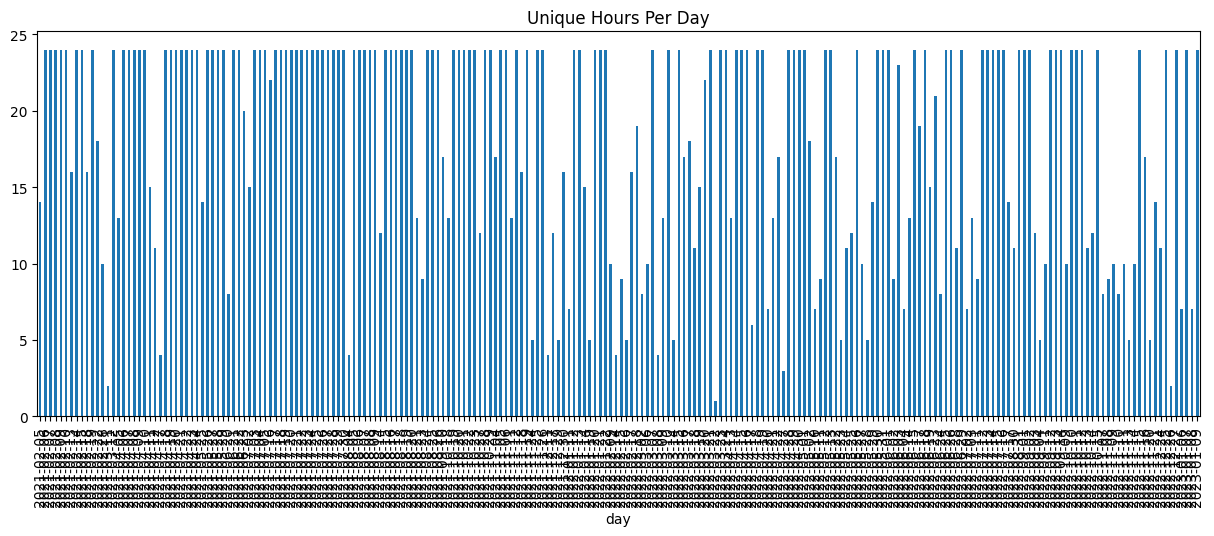

In [4]:
# Extract the date and hour from the timestamp
tweets_df['hour'] = tweets_df['date'].dt.hour
tweets_df['day'] = tweets_df['date'].dt.date

# Group by day and count the unique hours
unique_hours_per_day = tweets_df.groupby('day')['hour'].nunique()

# Plot the result
unique_hours_per_day.plot(kind='bar', figsize=(15, 5), title='Unique Hours Per Day')

In [5]:
import yfinance as yf

# Download BTC hourly data between the specified dates
btc_data = yf.download(tickers='BTC-USD', interval='1h', start="2021-01-01", end="2023-02-01")

# Display the first few rows of the data
print(btc_data.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BTC-USD']: YFPricesMissingError('possibly delisted; no price data found  (1h 2021-01-01 -> 2023-02-01) (Yahoo error = "1h data not available for startTime=1609459200 and endTime=1675209600. The requested range must be within the last 730 days.")')


Empty DataFrame
Columns: [(Adj Close, BTC-USD), (Close, BTC-USD), (High, BTC-USD), (Low, BTC-USD), (Open, BTC-USD), (Volume, BTC-USD)]
Index: []


In [7]:
import yfinance as yf
import pandas as pd

# Download hourly BTC-USD data
btc_hourly = yf.download(
    tickers='BTC-USD',
    start='2021-01-01',
    end='2023-02-01',
    interval='1h'  # hourly data
)

# Reset index to move datetime to a column if needed
btc_hourly.reset_index(inplace=True)

# Preview
print(btc_hourly.head())

# Save to parquet (recommended for efficiency)
btc_hourly.to_parquet('../datasets/btc_hourly_data.parquet')


[*********************100%***********************]  1 of 1 completed

1 Failed download:


['BTC-USD']: YFPricesMissingError('possibly delisted; no price data found  (1h 2021-01-01 -> 2023-02-01) (Yahoo error = "1h data not available for startTime=1609459200 and endTime=1675209600. The requested range must be within the last 730 days.")')


Empty DataFrame
Columns: [(Date, ), (Adj Close, BTC-USD), (Close, BTC-USD), (High, BTC-USD), (Low, BTC-USD), (Open, BTC-USD), (Volume, BTC-USD)]
Index: []


In [11]:
import requests
import pandas as pd
import datetime
import time

def get_binance_btc_hourly(start_str, end_str):
    url = 'https://api.binance.com/api/v3/klines'
    start_ts = int(datetime.datetime.strptime(start_str, "%Y-%m-%d").timestamp() * 1000)
    end_ts = int(datetime.datetime.strptime(end_str, "%Y-%m-%d").timestamp() * 1000)
    all_data = []

    while start_ts < end_ts:
        params = {
            'symbol': 'BTCUSDT',
            'interval': '1h',
            'startTime': start_ts,
            'endTime': min(start_ts + 1000 * 60 * 60 * 500, end_ts),  # max 500 hours per call
            'limit': 500
        }
        response = requests.get(url, params=params)
        data = response.json()
        if not data:
            break
        all_data.extend(data)
        start_ts = data[-1][0] + 3600000  # add 1 hour (in ms)

        time.sleep(1)  # to be polite to API

    # Convert to dataframe
    df = pd.DataFrame(all_data, columns=[
        'Open Time', 'Open', 'High', 'Low', 'Close', 'Volume',
        'Close Time', 'Quote Asset Volume', 'Number of Trades',
        'Taker Buy Base Volume', 'Taker Buy Quote Volume', 'Ignore'
    ])

    df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
    df.set_index('Open Time', inplace=True)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)
    return df

# Fetch and save
btc_hourly_df = get_binance_btc_hourly('2021-01-01', '2023-02-01')
btc_hourly_df.to_parquet('../datasets/btc_hourly_data.parquet')

print(btc_hourly_df.head())


{'code': 0, 'msg': "Service unavailable from a restricted location according to 'b. Eligibility' in https://www.binance.com/en/terms. Please contact customer service if you believe you received this message in error."}


KeyError: -1

In [20]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")

print("Path to dataset files:", path)

100%|██████████| 113M/113M [00:03<00:00, 35.8MB/s] 

Extracting files...


Path to dataset files: /Users/vamsisaigarapati/.cache/kagglehub/datasets/mczielinski/bitcoin-historical-data/versions/208


In [33]:
import os

# List all files in the directory
files = os.listdir(path)

# Display the files
print("Files in directory:", files)

# Read each file based on its extension
for file in files:
    file_path = os.path.join(path, file)
    if file.endswith('.csv'):
        df = pd.read_csv(file_path)
        print(f"Contents of {file}:")
        print(df.head())
    elif file.endswith('.parquet'):
        df = pd.read_parquet(file_path)
        print(f"Contents of {file}:")
        print(df.head())
    else:
        print(f"Skipping unsupported file type: {file}")

Files in directory: ['btcusd_1-min_data.csv']
Contents of btcusd_1-min_data.csv:
      Timestamp  Open  High   Low  Close  Volume                   datetime
0  1.325412e+09  4.58  4.58  4.58   4.58     0.0  2012-01-01 10:01:00+00:00
1  1.325412e+09  4.58  4.58  4.58   4.58     0.0  2012-01-01 10:02:00+00:00
2  1.325412e+09  4.58  4.58  4.58   4.58     0.0  2012-01-01 10:03:00+00:00
3  1.325412e+09  4.58  4.58  4.58   4.58     0.0  2012-01-01 10:04:00+00:00
4  1.325412e+09  4.58  4.58  4.58   4.58     0.0  2012-01-01 10:05:00+00:00


/var/folders/x5/7fmrypvd2mj6rc45kq6kv2lh0000gn/T/ipykernel_63062/4246611298.py:13: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [34]:
# Convert the 'Timestamp' column to a proper datetime format
df['timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

# Display the updated DataFrame
print(df.head())

      Timestamp  Open  High   Low  Close  Volume                   datetime  \
0  1.325412e+09  4.58  4.58  4.58   4.58     0.0  2012-01-01 10:01:00+00:00   
1  1.325412e+09  4.58  4.58  4.58   4.58     0.0  2012-01-01 10:02:00+00:00   
2  1.325412e+09  4.58  4.58  4.58   4.58     0.0  2012-01-01 10:03:00+00:00   
3  1.325412e+09  4.58  4.58  4.58   4.58     0.0  2012-01-01 10:04:00+00:00   
4  1.325412e+09  4.58  4.58  4.58   4.58     0.0  2012-01-01 10:05:00+00:00   

            timestamp  
0 2012-01-01 10:01:00  
1 2012-01-01 10:02:00  
2 2012-01-01 10:03:00  
3 2012-01-01 10:04:00  
4 2012-01-01 10:05:00  


In [35]:
min_datetime = df['timestamp'].min()
max_datetime = df['timestamp'].max()

print("Minimum datetime:", min_datetime)
print("Maximum datetime:", max_datetime)

Minimum datetime: 2012-01-01 10:01:00
Maximum datetime: 2025-04-17 00:43:00


In [36]:
# Filter the data between the specified dates
filtered_df = df[(df['timestamp'] >= '2021-01-01') & (df['timestamp'] <= '2023-02-01')]

# Display the filtered data
print(filtered_df.head())

            Timestamp      Open      High       Low     Close     Volume  \
4734119  1.609459e+09  28912.47  28940.00  28896.36  28897.20  14.556408   
4734120  1.609459e+09  28908.84  28928.51  28863.27  28863.27  17.718064   
4734121  1.609459e+09  28852.26  28861.48  28812.60  28829.36  19.585761   
4734122  1.609459e+09  28810.63  28817.79  28790.85  28807.63   9.808556   
4734123  1.609459e+09  28805.63  28808.51  28776.17  28807.69  10.101365   

                          datetime           timestamp  
4734119  2021-01-01 00:00:00+00:00 2021-01-01 00:00:00  
4734120  2021-01-01 00:01:00+00:00 2021-01-01 00:01:00  
4734121  2021-01-01 00:02:00+00:00 2021-01-01 00:02:00  
4734122  2021-01-01 00:03:00+00:00 2021-01-01 00:03:00  
4734123  2021-01-01 00:04:00+00:00 2021-01-01 00:04:00  


In [37]:
filtered_df.shape

(1095841, 8)

In [38]:
filtered_df.head()

,Timestamp,Open,High,Low,Close,Volume,datetime,timestamp
4734119,1.609459e+09,28912.47,28940.00,28896.36,28897.20,14.556408,2021-01-01 00:00:00+00:00,2021-01-01 00:00:00
4734120,1.609459e+09,28908.84,28928.51,28863.27,28863.27,17.718064,2021-01-01 00:01:00+00:00,2021-01-01 00:01:00
4734121,1.609459e+09,28852.26,28861.48,28812.60,28829.36,19.585761,2021-01-01 00:02:00+00:00,2021-01-01 00:02:00
4734122,1.609459e+09,28810.63,28817.79,28790.85,28807.63,9.808556,2021-01-01 00:03:00+00:00,2021-01-01 00:03:00
4734123,1.609459e+09,28805.63,28808.51,28776.17,28807.69,10.101365,2021-01-01 00:04:00+00:00,2021-01-01 00:04:00


In [39]:
# Filter rows where the minute in the datetime column is 0
filtered_df = filtered_df[filtered_df['timestamp'].dt.minute == 0]

# Drop the 'Timestamp' and 'timestamp' columns
filtered_df = filtered_df.drop(columns=['Timestamp', 'datetime'])

# Display the filtered DataFrame
print(filtered_df.head())

             Open      High       Low     Close     Volume           timestamp
4734119  28912.47  28940.00  28896.36  28897.20  14.556408 2021-01-01 00:00:00
4734179  28949.71  28971.19  28934.74  28951.62   2.909250 2021-01-01 01:00:00
4734239  29200.00  29200.00  29141.89  29182.39   6.573420 2021-01-01 02:00:00
4734299  28987.60  29036.54  28987.60  29036.54   2.058270 2021-01-01 03:00:00
4734359  29135.25  29161.46  29084.48  29086.47   4.388466 2021-01-01 04:00:00


In [40]:
filtered_df = filtered_df.rename(columns={'timestamp': 'datetime'})
filtered_df = filtered_df[['datetime'] + [col for col in filtered_df.columns if col != 'datetime']]

# Display the updated DataFrame
print(filtered_df.head())

                   datetime      Open      High       Low     Close     Volume
4734119 2021-01-01 00:00:00  28912.47  28940.00  28896.36  28897.20  14.556408
4734179 2021-01-01 01:00:00  28949.71  28971.19  28934.74  28951.62   2.909250
4734239 2021-01-01 02:00:00  29200.00  29200.00  29141.89  29182.39   6.573420
4734299 2021-01-01 03:00:00  28987.60  29036.54  28987.60  29036.54   2.058270
4734359 2021-01-01 04:00:00  29135.25  29161.46  29084.48  29086.47   4.388466


In [42]:
filtered_df.to_parquet('../datasets/btc_data_hourly.parquet', index=False)

In [43]:
filtered_df.shape

(18265, 6)